In [1]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

# Bibliotecas complementares
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats


#Settings
Ncm.cfg_init()

%matplotlib inline
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

In [2]:
# DC2 data

DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits"
)
dt_halos = Table(DC2_halos_m200c[1].data)

# dt_halos['redshift_true', 'mass_fof', 'm200c', 'richness']

In [3]:
rmdata = create_richness_mass_calib(dt_halos)

ascaso = Nc.ClusterMassAscaso()
ascaso.param_set_by_name("mup0", 4.08763247333783)
ascaso.param_set_by_name("mup1", 0.538092645909241)
ascaso.param_set_by_name("mup2", 0.931306629373459)
ascaso.param_set_by_name("sigmap0", 0.674689968522022)
ascaso.param_set_by_name("sigmap1", 0.0645030252979038)
ascaso.param_set_by_name("sigmap2", -0.244363116863723)

mset = Ncm.MSet()
mset.set(ascaso)

In [4]:
lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

In [5]:
# lnR mean and std

lnR_mean = np.array(
    [ascaso.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
)
lnR_std = np.array(
    [ascaso.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
)

Text(0, 0.5, 'Residuals')

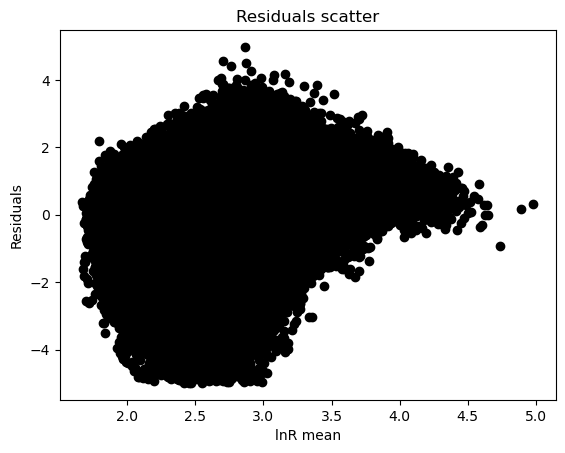

In [6]:
# Residuals

abs_err = (lnR - lnR_mean) / lnR_std

# Data cut

sigma_cut = 5.0

lnR_mean = lnR_mean[np.abs(abs_err) < sigma_cut]
z_sigma_cut = z[np.abs(abs_err) < sigma_cut]
lnM_sigma_cut = lnM[np.abs(abs_err) < sigma_cut]
abs_err = abs_err[np.abs(abs_err) < sigma_cut]

plt.scatter(lnR_mean, abs_err, c="k")
#plt.axline(xy1=(0, 0), slope=0, c="red")
plt.title("Residuals scatter")
plt.xlabel("lnR mean")
plt.ylabel("Residuals")

Text(0.5, 1.0, 'Residuals distribuition')

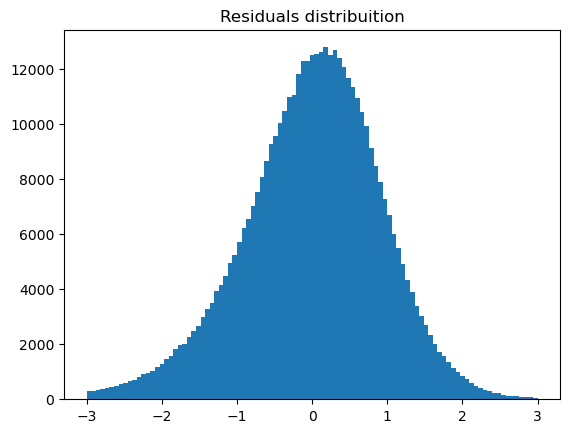

In [7]:
plt.hist(abs_err, bins=np.linspace(-3, 3, 100))
plt.title("Residuals distribuition")

In [8]:
print(stats.shapiro(abs_err))
print(stats.kstest(abs_err, "norm"))

ShapiroResult(statistic=0.9856353402137756, pvalue=0.0)
KstestResult(statistic=0.03581490144816357, pvalue=0.0, statistic_location=-0.46805537255761726, statistic_sign=-1)


/global/homes/v/vitenti/.conda/envs/numcosmo/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [9]:
print(f"mean {np.mean(abs_err)} std {np.std(abs_err)}")

mean -0.014680669647036928 std 0.9499027828403532


In [10]:
# fig = plt.figure()
# ax = fig.add_subplot()
# stats.probplot(abs_err, dist="norm", plot=ax)
# plt.show()

Text(0.5, 1.0, 'Redshift distribuition')

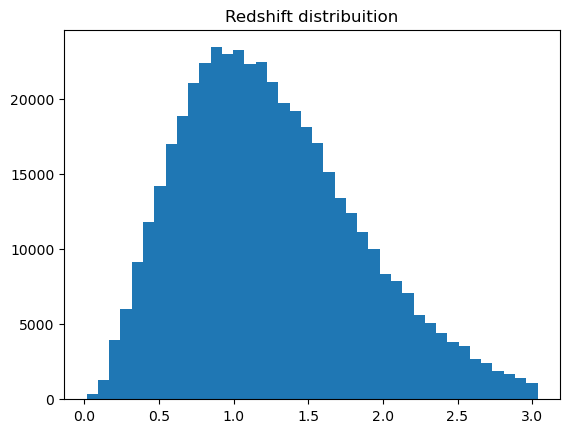

In [11]:
plt.hist(z, bins=40)
plt.title("Redshift distribuition")

In [12]:
z_sigma_cut_cut = np.logical_and(z_sigma_cut > 0.1, z_sigma_cut < 0.4)

Text(0.5, 1.0, 'Residuals distribuition')

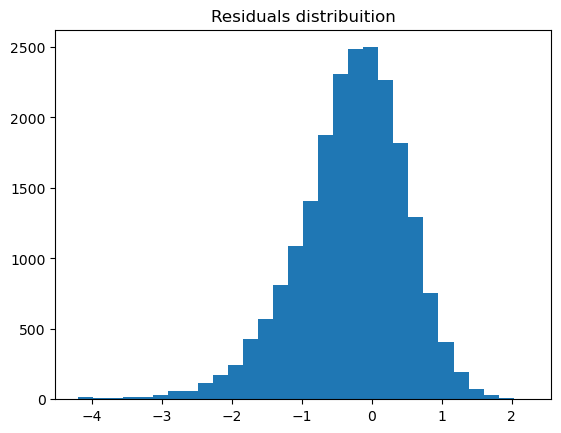

In [13]:
plt.hist(abs_err[z_sigma_cut_cut], bins=30)
plt.title("Residuals distribuition")

Text(0.5, 1.0, 'Mass distribuition')

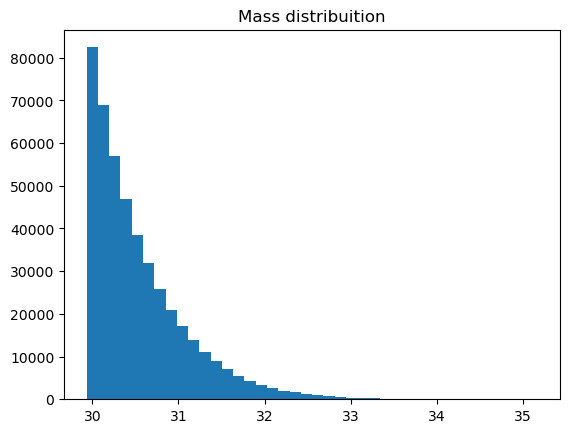

In [14]:
plt.hist(lnM_sigma_cut, bins=40)
plt.title("Mass distribuition")

In [15]:
print(f"{np.exp(min(lnM_sigma_cut)):e}")

1.000236e+13


In [16]:
lnM_sigma_cut_cut = np.logical_and(lnM_sigma_cut > 31.0, lnM_sigma_cut < 31.2)

Text(0.5, 1.0, 'Residuals distribuition')

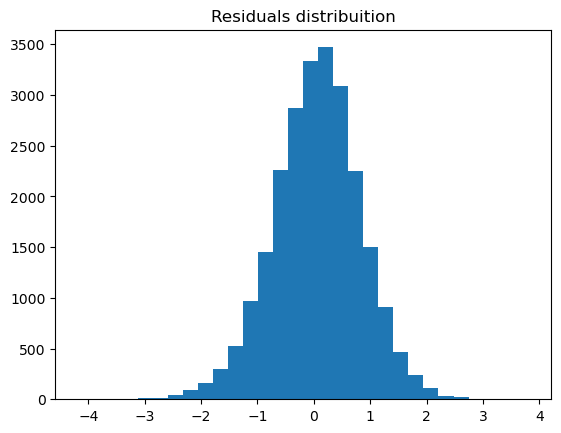

In [17]:
plt.hist(abs_err[lnM_sigma_cut_cut], bins=30)
plt.title("Residuals distribuition")

In [18]:
print(f"{stats.skew(abs_err)} {stats.kurtosis(abs_err)}")

-0.49667885415549856 1.0385730325705005


In [19]:
stats.kurtosis(np.random.normal(0, 1, 10000))

0.11021745263480387

In [20]:
# MCMC
# Parameters posterior distribuition

# mcmc_fits = Table(fits.open('NumCosmo/MCMC_ascaso_test.fits')[1].data) #MCMC first results

dt_mcmc = list(Table(fits.open("MCMC_ascaso_test.fits")[1].data))

df = pd.DataFrame(dt_mcmc)
df.columns = ["m2lnL", "mup0", "mup1", "mup2", "sigmap0", "sigmap1", "sigmap2"]

df_param = df[["mup0", "mup1", "mup2", "sigmap0", "sigmap1", "sigmap2"]]

/global/homes/c/cinlima/.conda/envs/numcosmo/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


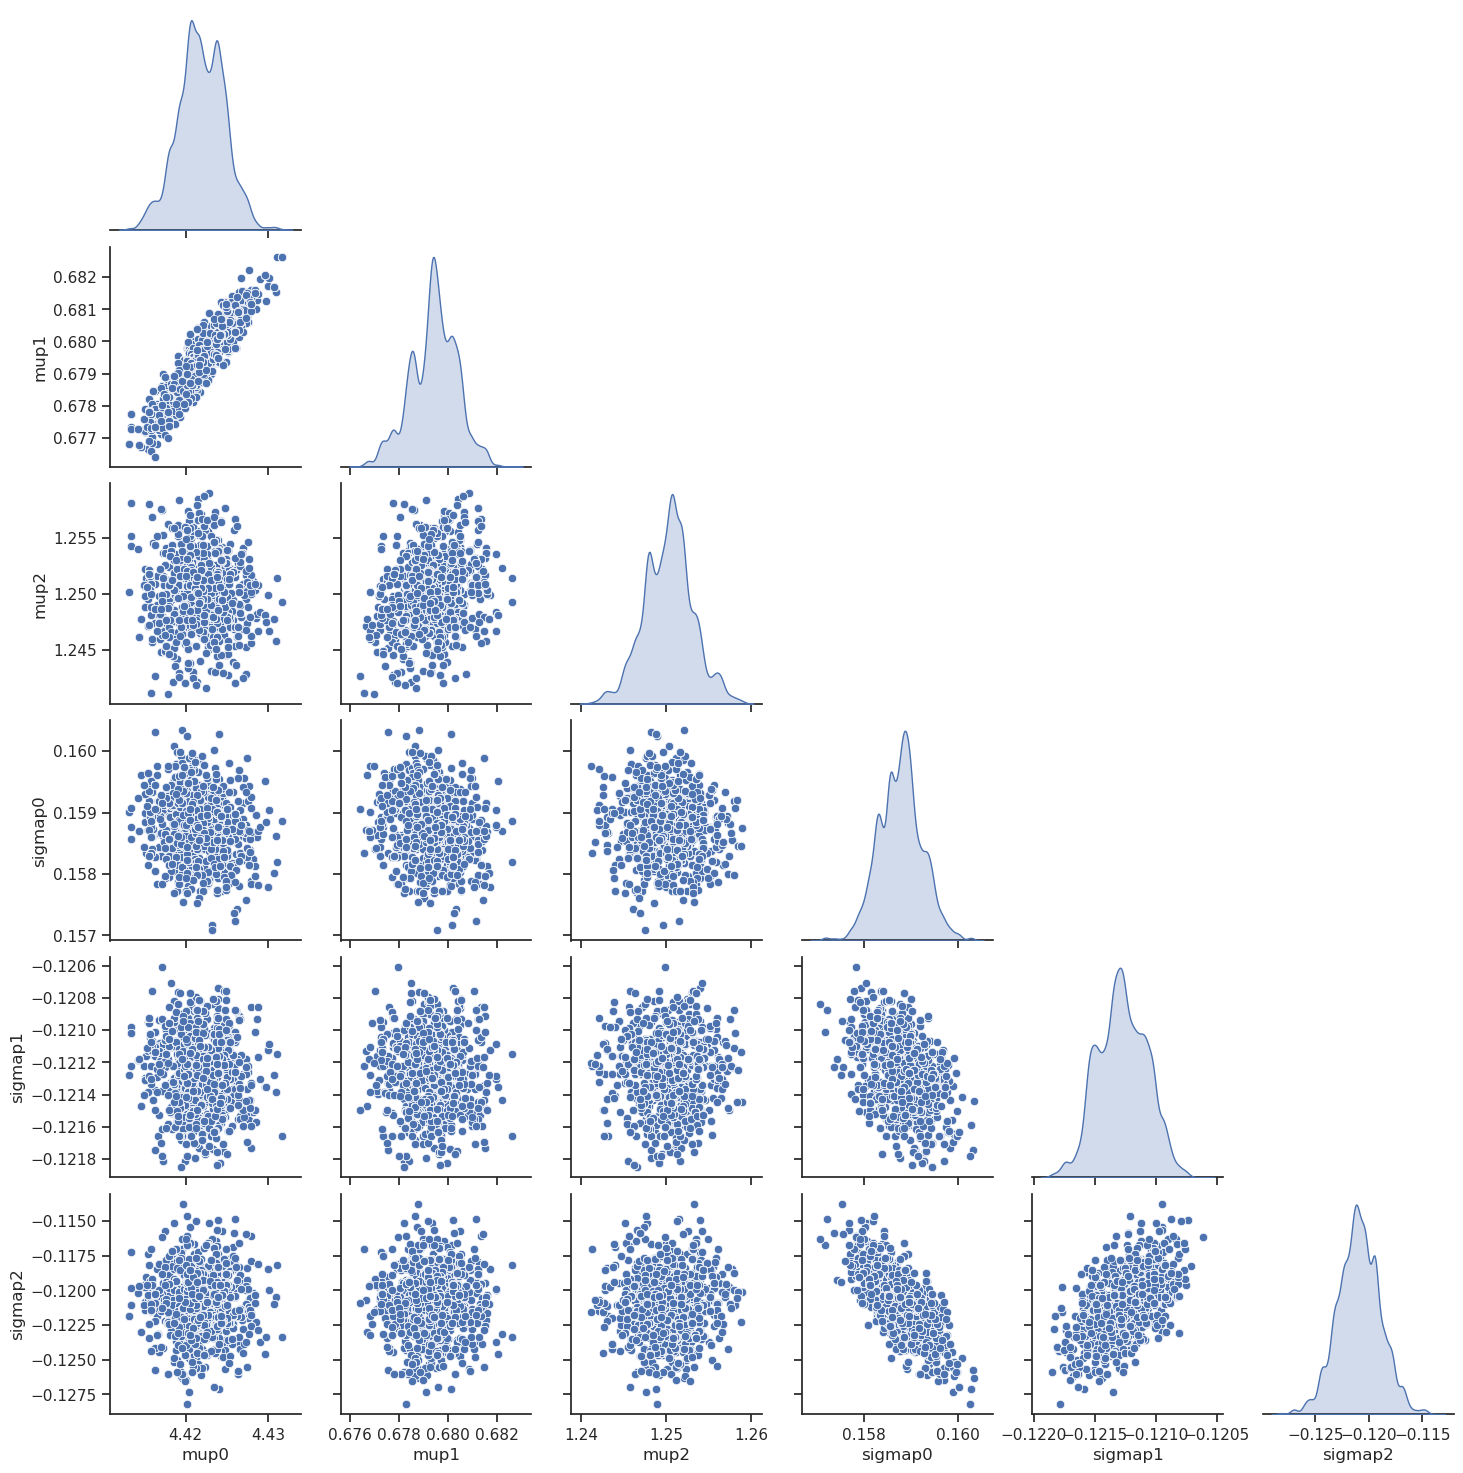

In [21]:
sns.set_theme(style="ticks", color_codes="r")
sns.pairplot(data=df_param, corner=True, diag_kind="kde")

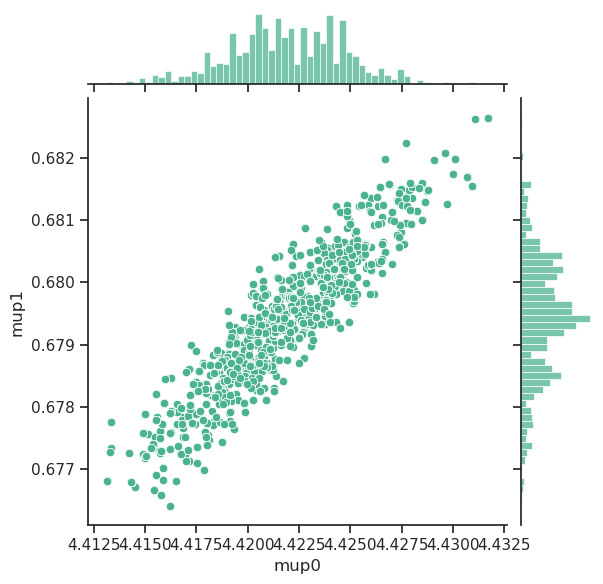

In [22]:
sns.jointplot(x=df_param["mup0"], y=df_param["mup1"], color="#4CB391")

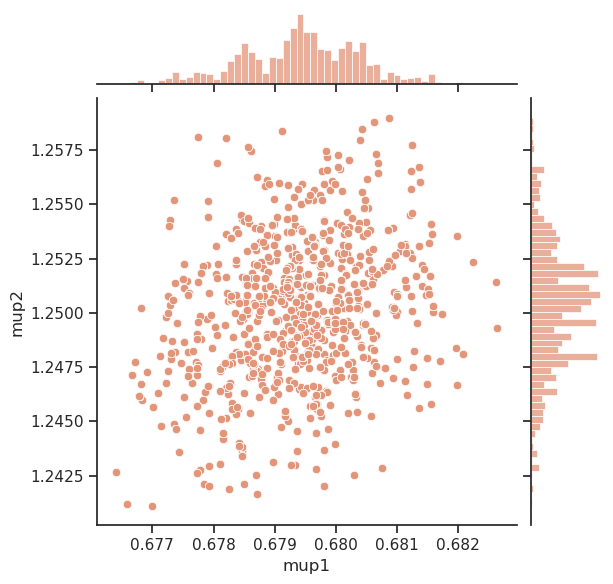

In [23]:
sns.jointplot(x=df_param["mup1"], y=df_param["mup2"], color="#E29578")

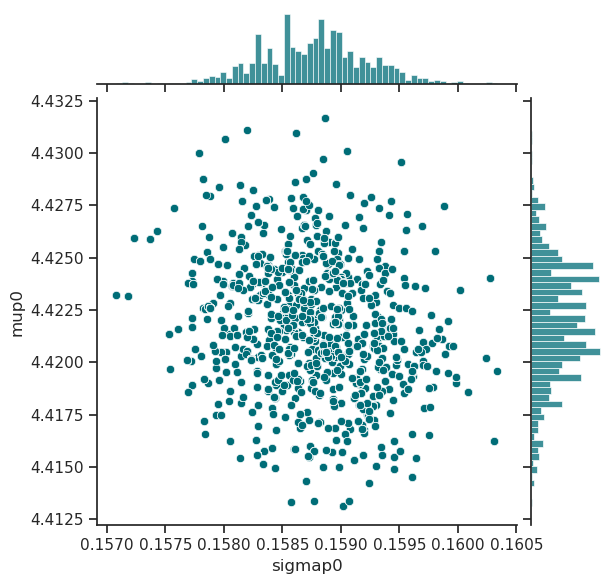

In [24]:
sns.jointplot(x=df_param["sigmap0"], y=df_param["mup0"], color="#006D77")